Copyright (c) MONAI Consortium  
Licensed under the Apache License, Version 2.0 (the "License");  
you may not use this file except in compliance with the License.  
You may obtain a copy of the License at  
&nbsp;&nbsp;&nbsp;&nbsp;http://www.apache.org/licenses/LICENSE-2.0  
Unless required by applicable law or agreed to in writing, software  
distributed under the License is distributed on an "AS IS" BASIS,  
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.  
See the License for the specific language governing permissions and  
limitations under the License.

# MONAI @ Learn2Reg Challenge
## NLST Task: Paired Lung CT 3D Registration with Keypoints

### **Update**: MONAI submission [finished 3rd](https://learn2reg.grand-challenge.org/) in the Learn2Reg challenge

This tutorial shows how to use MONAI to register CT images acquired at different time points for a single patient. It is a fully MONAI-based solution for the [NLST track](https://learn2reg.grand-challenge.org/Datasets/) of the [Learn2Reg challenge 2023](https://learn2reg.grand-challenge.org/). The images being registered are taken at inspiration and expiration for each subject. This is an intra subject registration. This type of intra subject registration is useful when there is a need to track certain features on a medical image such as tumor location when conducting invasive procedures. 

<h4><center>Registration sample from NLST challenge</center></h4>

| Pre-registration | Post-registration |
| --- | --- |
| ![Sample from the NLST challenge pre-reg](https://rumc-gcorg-p-public.s3.amazonaws.com/i/2022/05/17/Image_Pasted_at_2022-5-12_18-451.png "Before") |  ![Sample from the NLST challenge post-reg](https://rumc-gcorg-p-public.s3.amazonaws.com/i/2022/05/17/Image_Pasted_at_2022-5-12_18-45.png "After") |


Importantly, the NLST dataset does not only contain images. Instead, every inhale-exhale CT sample contains:
1. A CT volume of the torso.
1. A lung mask for loss computation or evaluation. 
1. Keypoints that match anatomic landmarks between inhale-exhale volume pairs. These were auto-detected in a pre-processing step, and like mask, can be used for loss computation and evaluation metric.

The challenge evaluation only considers a single metric: Target-registration-error (TRE) between the target points and the transformed locations of the moving points. 

This tutorial demonstrates several MONAI principles and has the following features:
1. Load NLST challenge data with images, masks and keypoints
1. Define transforms and augmentations for paired data in dictionary format
1. Define custom transforms for 3D pointclouds: `LoadKeypointsd` and `TransformKeypointsd`
1. Fast data loading and batching with `CacheDataset` and `DataLoader` 
1. Build `SegResNet` and custom forward function for prediction of dense displacement fields (DDF)
1. Warp an image with predicted DDFs and Warp block
1. Build a custom and flexible multi-target loss function for various registration tasks, using a combination of loss functions from MONAI, PyTorch and custom code
1. Compute mean Dice overlap metric on lung masks for validation

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Project-MONAI/tutorials/blob/main/3d_registration/learn2reg_nlst_paired_lung_ct.ipynb)

## Setup environment

In [ ]:
!python -c "import monai" || pip install -q "monai-weekly[nibabel, tqdm]"
!python -c "import matplotlib" || pip install -q matplotlib
%matplotlib inline

## Setup imports

In [3]:
# python imports
import os
import glob
import json
import time
import tempfile
import warnings
from pprint import pprint

# data science imports
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# PyTorch imports
import torch
import torch.nn.functional as F
from torch.nn import MSELoss
from torch.utils.tensorboard import SummaryWriter

# MONAI imports
from monai.apps import download_and_extract
from monai.data import Dataset, CacheDataset, DataLoader
from monai.data.utils import list_data_collate
from monai.losses import BendingEnergyLoss, DiceLoss
from monai.metrics import DiceMetric
from monai.networks.blocks import Warp
from monai.networks.nets import SegResNet
from monai.utils import set_determinism, first
from monai.config import print_config
from monai.transforms import (
    Compose,
    LoadImaged,
    MapTransform,
    RandAffined,
    Resized,
    ScaleIntensityRanged,
)

set_determinism(seed=0)
torch.backends.cudnn.benchmark = True
warnings.filterwarnings("ignore")

print_config()

MONAI version: 1.2.0
Numpy version: 1.22.2
Pytorch version: 2.0.0a0+1767026
MONAI flags: HAS_EXT = True, USE_COMPILED = False, USE_META_DICT = False
MONAI rev id: c33f1ba588ee00229a309000e888f9817b4f1934
MONAI __file__: /opt/monai/monai/__init__.py

Optional dependencies:
Pytorch Ignite version: 0.4.11
ITK version: 5.3.0
Nibabel version: 5.1.0
scikit-image version: 0.21.0
Pillow version: 9.2.0
Tensorboard version: 2.9.0
gdown version: 4.7.1
TorchVision version: 0.15.0a0
tqdm version: 4.65.0
lmdb version: 1.4.1
psutil version: 5.9.4
pandas version: 1.5.2
einops version: 0.6.1
transformers version: 4.21.3
mlflow version: 2.4.0
pynrrd version: 1.0.0

For details about installing the optional dependencies, please visit:
    https://docs.monai.io/en/latest/installation.html#installing-the-recommended-dependencies



## Setup data directory

You can specify a directory with the `MONAI_DATA_DIRECTORY` environment variable.
This allows you to save results and reuse downloads.
If not specified a temporary directory will be used.

In [5]:
directory = os.environ.get("MONAI_DATA_DIRECTORY")
root_dir = tempfile.mkdtemp() if directory is None else directory
print(root_dir)

/data/Projects/MONAI-registration/monai-registration/data


## Download dataset and prepare datalist
Download and extract the dataset:

In [6]:
resource = "https://cloud.imi.uni-luebeck.de/s/pERQBNyEFNLY8gR/download/NLST2023.zip"

compressed_file = os.path.join(root_dir, "NLST2023.zip")
data_dir = os.path.join(root_dir, "NLST")
if not os.path.exists(data_dir):
    download_and_extract(resource, compressed_file, root_dir)

Get list of samples in the dataset:

In [7]:
def get_files(data_dir):
    """
    Get L2R train/val files from NLST challenge
    """
    data_json = os.path.join(data_dir, "NLST_dataset.json")

    with open(data_json) as file:
        data = json.load(file)

    train_files = []
    for pair in data["training_paired_images"]:
        nam_fixed = os.path.basename(pair["fixed"]).split(".")[0]
        nam_moving = os.path.basename(pair["moving"]).split(".")[0]
        train_files.append(
            {
                "fixed_image": os.path.join(data_dir, "imagesTr", nam_fixed + ".nii.gz"),
                "moving_image": os.path.join(data_dir, "imagesTr", nam_moving + ".nii.gz"),
                "fixed_label": os.path.join(data_dir, "masksTr", nam_fixed + ".nii.gz"),
                "moving_label": os.path.join(data_dir, "masksTr", nam_moving + ".nii.gz"),
                "fixed_keypoints": os.path.join(data_dir, "keypointsTr", nam_fixed + ".csv"),
                "moving_keypoints": os.path.join(data_dir, "keypointsTr", nam_moving + ".csv"),
            }
        )

    val_files = []
    for pair in data["registration_val"]:
        nam_fixed = os.path.basename(pair["fixed"]).split(".")[0]
        nam_moving = os.path.basename(pair["moving"]).split(".")[0]
        val_files.append(
            {
                "fixed_image": os.path.join(data_dir, "imagesTr", nam_fixed + ".nii.gz"),
                "moving_image": os.path.join(data_dir, "imagesTr", nam_moving + ".nii.gz"),
                "fixed_label": os.path.join(data_dir, "masksTr", nam_fixed + ".nii.gz"),
                "moving_label": os.path.join(data_dir, "masksTr", nam_moving + ".nii.gz"),
                "fixed_keypoints": os.path.join(data_dir, "keypointsTr", nam_fixed + ".csv"),
                "moving_keypoints": os.path.join(data_dir, "keypointsTr", nam_moving + ".csv"),
            }
        )

    return train_files, val_files


train_files, val_files = get_files(data_dir)

# print 2 training samples to illustrate the contents of the datalist
pprint(train_files[0:2])

[{'fixed_image': '/data/Projects/MONAI-registration/monai-registration/data/NLST/imagesTr/NLST_0001_0000.nii.gz',
  'fixed_keypoints': '/data/Projects/MONAI-registration/monai-registration/data/NLST/keypointsTr/NLST_0001_0000.csv',
  'fixed_label': '/data/Projects/MONAI-registration/monai-registration/data/NLST/masksTr/NLST_0001_0000.nii.gz',
  'moving_image': '/data/Projects/MONAI-registration/monai-registration/data/NLST/imagesTr/NLST_0001_0001.nii.gz',
  'moving_keypoints': '/data/Projects/MONAI-registration/monai-registration/data/NLST/keypointsTr/NLST_0001_0001.csv',
  'moving_label': '/data/Projects/MONAI-registration/monai-registration/data/NLST/masksTr/NLST_0001_0001.nii.gz'},
 {'fixed_image': '/data/Projects/MONAI-registration/monai-registration/data/NLST/imagesTr/NLST_0002_0000.nii.gz',
  'fixed_keypoints': '/data/Projects/MONAI-registration/monai-registration/data/NLST/keypointsTr/NLST_0002_0000.csv',
  'fixed_label': '/data/Projects/MONAI-registration/monai-registration/dat

## Define transforms for pre-processing and augmentation

### Transforms Step 1/2: Define custom transforms for point-clouds

Transforms in MONAI are mostly designed for images, especially spatial transforms like rigid/affine or non-linear transformation of voxel grids. Since NLST also provides us with keypoints, however, we need to design custom transforms that can transform points clouds. Specifically, we need to1) load points from CSV files and 2) linearly transform them exactly in the same way as the underlying image was transformed (e.g. due to affine transformation during augmentation). 

These transforms are defined here, inheriting from `MapTransform`, the base class for dictionary transforms (for more information on vanilla transforms vs. dictionary transforms, visit the [3D Image Transforms tutorial](../modules/3d_image_transforms.ipynb)).

In [6]:
class LoadKeypointsd(MapTransform):
    """
    Load keypoints from csv file
    """

    def __call__(self, data):
        d = dict(data)
        for key in self.keys:
            keypoints = d[key]
            keypoints = pd.read_csv(keypoints, header=None)
            keypoints = keypoints.to_numpy()
            keypoints = torch.as_tensor(keypoints)
            d[key] = keypoints  # [N, 3]
        return d


class TransformKeypointsd(MapTransform):
    """
    Applies any potential linear image transformation to keypoint values
    """

    def __init__(self, keys_keypoints, keys_images, ras=False):
        # super.__init__(self)
        self.keys_keypoints = keys_keypoints
        self.keys_images = keys_images
        self.ras = ras

    def __call__(self, data):
        d = dict(data)
        for kp, ki in zip(self.keys_keypoints, self.keys_images):
            # Get image meta data
            image = d[ki]
            meta = image.meta
            # Get keypoints
            keypoints_ijk = d[kp]
            # Get transformation (in voxel space)
            affine = meta["affine"]
            original_affine = torch.as_tensor(meta["original_affine"], dtype=affine.dtype, device=affine.device)
            transforms_affine = (
                original_affine.inverse() @ affine
            )  # Assumes: affine = original_affine @ transforms_affine
            transforms_affine = transforms_affine.inverse()
            if self.ras:
                # RAS space
                transforms_affine = original_affine @ transforms_affine
            # Apply transformation to keypoints
            keypoints_ijk_moved = torch.cat((keypoints_ijk, torch.ones((keypoints_ijk.shape[0]), 1)), dim=1)
            keypoints_ijk_moved = (transforms_affine @ keypoints_ijk_moved.T).T
            keypoints_ijk_moved = keypoints_ijk_moved[:, :3]
            keypoints_ijk_moved = keypoints_ijk_moved.float()

            d[kp] = keypoints_ijk_moved  # [N, 3]

        return d

<a id='transforms_step2'></a>
### Transforms Step 2/2: Define transform pipelines for training and validation

In the following transform chains, please note that the keypoint transforms are loaded _last_. I.e., they can only be loaded _after_ all image transforms have been applied. This is necessary because we need to know the final affine matrix in the volume's meta-tensor and compare it to the original meta-tensor, in order to determine how the points clouds need to be transformed. 

In [7]:
full_res_training = False
if full_res_training:
    target_res = [224, 192, 224]
    spatial_size = [
        -1,
        -1,
        -1,
    ]  # for Resized transform, [-1, -1, -1] means no resizing, use this when training challenge model
else:
    target_res = [96, 96, 96]
    spatial_size = target_res  # downsample to 96^3 voxels for faster training on resized data (good for testing)

train_transforms = Compose(
    [
        LoadImaged(keys=["fixed_image", "moving_image", "fixed_label", "moving_label"], ensure_channel_first=True),
        LoadKeypointsd(
            keys=["fixed_keypoints", "moving_keypoints"],
        ),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-1200,
            a_max=400,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=("trilinear", "trilinear", "nearest", "nearest"),
            align_corners=(True, True, None, None),
            spatial_size=spatial_size,
        ),
        RandAffined(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=("bilinear", "bilinear", "nearest", "nearest"),
            prob=0.8,
            shear_range=0.2,
            translate_range=int(25 * target_res[0] / 224),
            rotate_range=np.pi / 180 * 15,
            scale_range=0.2,
            padding_mode=("zeros", "zeros", "zeros", "zeros"),
        ),
        TransformKeypointsd(
            keys_keypoints=["fixed_keypoints", "moving_keypoints"],
            keys_images=["fixed_image", "moving_image"],
        ),
    ]
)

val_transforms = Compose(
    [
        LoadImaged(keys=["fixed_image", "moving_image", "fixed_label", "moving_label"], ensure_channel_first=True),
        ScaleIntensityRanged(
            keys=["fixed_image", "moving_image"],
            a_min=-1200,
            a_max=400,
            b_min=0.0,
            b_max=1.0,
            clip=True,
        ),
        Resized(
            keys=["fixed_image", "moving_image", "fixed_label", "moving_label"],
            mode=("trilinear", "trilinear", "nearest", "nearest"),
            align_corners=(True, True, None, None),
            spatial_size=spatial_size,
        ),
        LoadKeypointsd(
            keys=["fixed_keypoints", "moving_keypoints"],
        ),
        TransformKeypointsd(
            keys_keypoints=["fixed_keypoints", "moving_keypoints"],
            keys_images=["fixed_image", "moving_image"],
        ),
    ]
)

## Check transforms in DataLoader

Visualize a single batch with a single sample to check the transforms.

fixed_image shape: torch.Size([96, 96, 96]), fixed_label shape: torch.Size([96, 96, 96])
moving_image shape: torch.Size([96, 96, 96]), moving_label shape: torch.Size([96, 96, 96])


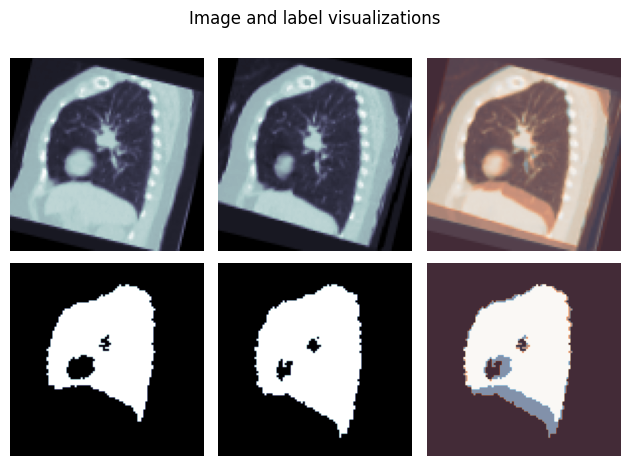

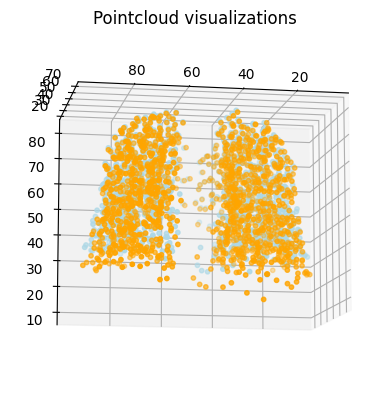

In [8]:
def overlay_img(img1, img2, slice_idx, ax, title=None):
    ax.imshow(1 - img1[:, slice_idx, :].T, cmap="Blues", origin="lower")
    ax.imshow(1 - img2[:, slice_idx, :].T, cmap="Oranges", origin="lower", alpha=0.5)
    if title is not None:
        ax.title.set_text(title)


set_determinism(seed=0)
check_ds = Dataset(data=train_files, transform=train_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Resampled image size
fixed_image = check_data["fixed_image"][0][0]
fixed_label = check_data["fixed_label"][0][0]
moving_image = check_data["moving_image"][0][0]
moving_label = check_data["moving_label"][0][0]
print(f"fixed_image shape: {fixed_image.shape}, " f"fixed_label shape: {fixed_label.shape}")
print(f"moving_image shape: {moving_image.shape}, " f"moving_label shape: {moving_label.shape}")

# Reorder dims for visualization
fixed_image = fixed_image.permute(1, 0, 2)
fixed_label = fixed_label.permute(1, 0, 2)
moving_image = moving_image.permute(1, 0, 2)
moving_label = moving_label.permute(1, 0, 2)

# Image and label visualization
slice_idx = int(target_res[0] * 95.0 / 224)  # at full-res (224 slices), visualize sagittal slice 95
fig, axs = plt.subplots(2, 3)
# plot images
axs[0, 0].imshow(fixed_image[:, slice_idx, :].T, cmap="bone", origin="lower")
axs[0, 1].imshow(moving_image[:, slice_idx, :].T, cmap="bone", origin="lower")
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 2])
# plot labels
axs[1, 0].imshow(fixed_label[:, slice_idx, :].T, cmap="bone", origin="lower")
axs[1, 1].imshow(moving_label[:, slice_idx, :].T, cmap="bone", origin="lower")
overlay_img(fixed_label, moving_label, slice_idx, axs[1, 2])
for ax in axs.ravel():
    ax.set_axis_off()
plt.suptitle("Image and label visualizations")
plt.tight_layout()
plt.show()

# Pointcloud visualization
fixed_points = check_data["fixed_keypoints"][0]
moving_points = check_data["moving_keypoints"][0]
fig = plt.figure()
ax = fig.add_subplot(projection="3d")
ax.scatter(fixed_points[:, 0], fixed_points[:, 1], fixed_points[:, 2], s=10.0, marker="o", color="lightblue")
ax.scatter(moving_points[:, 0], moving_points[:, 1], moving_points[:, 2], s=10.0, marker="o", color="orange")
ax.view_init(-10, 80)
ax.set_aspect("auto")
plt.title("Pointcloud visualizations")
plt.show()

<a id='hyperparameters'></a>
## Set hyperparameters

A lot of customization and hyperparameter search can go into the exploration loss weights below. In this example, we will let the optimization be driven only by TRE loss.

In [9]:
# device, optimizer, epoch and batch settings
device = "cuda:0"
batch_size = 4
lr = 1e-4
weight_decay = 1e-5
max_epochs = 200

# image voxel size at target resolution
vx = np.array([1.5, 1.5, 1.5]) / (np.array(target_res) / np.array([224, 192, 224]))
vx = torch.tensor(vx).to(device)

# Use mixed precision feature of GPUs for faster training
amp_enabled = True

# loss weights (set to zero to disable loss term)
lam_t = 1e0  # TRE  (keypoint loss)
lam_l = 0  # Dice (mask overlay)
lam_m = 0  # MSE (image similarity)
lam_r = 0  # Bending loss (smoothness of the DDF)

#  Write model and tensorboard logs?
do_save = True
dir_save = os.path.join(os.getcwd(), "models", "nlst", "tre-segresnet")
if do_save and not os.path.exists(dir_save):
    os.makedirs(dir_save)

## Create custom forward pass/collate function

In [10]:
def forward(fixed_image, moving_image, moving_label, fixed_keypoints, model, warp_layer):
    """
    Model forward pass: predict DDF, warp moving images/labels/keypoints
    """
    batch_size = fixed_image.shape[0]

    # predict DDF through LocalNet
    ddf_image = model(torch.cat((moving_image, fixed_image), dim=1)).float()

    # warp moving image and label with the predicted ddf
    pred_image = warp_layer(moving_image, ddf_image)

    # warp moving label (optional)
    if moving_label is not None:
        pred_label = warp_layer(moving_label, ddf_image)
    else:
        pred_label = None

    # warp vectors for keypoints (optional)
    if fixed_keypoints is not None:
        with torch.no_grad():
            offset = torch.as_tensor(fixed_image.shape[-3:]).to(fixed_keypoints.device) / 2
            offset = offset[None][None]
            ddf_keypoints = torch.flip((fixed_keypoints - offset) / offset, (-1,))
        ddf_keypoints = (
            F.grid_sample(ddf_image, ddf_keypoints.view(batch_size, -1, 1, 1, 3))
            .view(batch_size, 3, -1)
            .permute((0, 2, 1))
        )
    else:
        ddf_keypoints = None

    return ddf_image, ddf_keypoints, pred_image, pred_label


def collate_fn(batch):
    """
    Custom collate function.
    Some background:
        Collation is the "collapsing" of a list of N-dimensional tensors into a single (N+1)-dimensional tensor.
        The `Dataloader` object  performs this step after receiving a batch of (transformed) data from the
        `Dataset` object.
        Note that the `Resized` transform above resamples all image tensors to a shape `spatial_size`,
        thus images can be easily collated.
        Keypoints, however, are of different row-size and thus cannot be easily collated
        (a.k.a. "ragged" or "jagged" tensors): [(n_0, 3), (n_1, 3), ...]
        This function aligns the row-size of these tensors such that they can be collated like
        any regular list of tensors.
        To do this, the max number of keypoints is determined, and shorter keypoint-lists are filled up with NaNs.
        Then, the average-TRE loss below can be computed via `nanmean` aggregation (i.e. ignoring filled-up elements).
    """
    max_length = 0
    for data in batch:
        length = data["fixed_keypoints"].shape[0]
        if length > max_length:
            max_length = length
    for data in batch:
        length = data["fixed_keypoints"].shape[0]
        data["fixed_keypoints"] = torch.concat(
            (data["fixed_keypoints"], float("nan") * torch.ones((max_length - length, 3))), dim=0
        )
        data["moving_keypoints"] = torch.concat(
            (data["moving_keypoints"], float("nan") * torch.ones((max_length - length, 3))), dim=0
        )

    return list_data_collate(batch)

## Flexible multi-target loss function for various registration tasks

The custom method `loss_fun` below is a multi-target loss function which can be parameterized to steer model training towards a (weighted) combination of keypoint matching, image similarity, labelmap overlap and/or warp field regularization. This makes it very flexible to use for registration tasks with or without keypoints and labelmaps.

Out of the box, MONAI has several losses in store that can be used to train a deep (medical) image registration model: 
- Single-modal image similarity via LNCC ([LocalNormalizedCrossCorrelationLoss](https://docs.monai.io/en/stable/losses.html#localnormalizedcrosscorrelationloss)).
- Multi-modal image similarity via mutual information ([GlobalMutualInformationLoss](https://docs.monai.io/en/stable/losses.html#globalmutualinformationloss))
- Warp field regularization ([BendingEnergyLoss](https://docs.monai.io/en/stable/losses.html#bendingenergyloss))

The `loss_fun` further demonstrates that it is natively possible to incorporate PyTorch losses (e.g. [MESLoss](https://pytorch.org/docs/stable/generated/torch.nn.MSELoss.html)) or custom torch-based losses (see function `tre` below).

To get started, the weights in this tutorial are set to train the model purely on TRE (see "[Hyperparameters](#hyperparameters)"), however further experiments with different weight combinations are encouraged (see "[Next Steps](#nextsteps)").

In [ ]:
def tre(fixed, moving, vx=None):
    """
    Computes target registration error (TRE) loss for keypoint matching.
    """
    if vx is None:
        return ((fixed - moving) ** 2).sum(-1).sqrt().nanmean()
    else:
        return ((fixed - moving).mul(vx) ** 2).sum(-1).sqrt().nanmean()


def loss_fun(
    fixed_image,
    pred_image,
    fixed_label,
    pred_label,
    fixed_keypoints,
    pred_keypoints,
    ddf_image,
    lam_t,
    lam_l,
    lam_m,
    lam_r,
):
    """
    Custom multi-target loss:
        - TRE as main loss component
        - Parametrizable weights for further (optional) components: MSE/BendingEnergy/Dice loss
    Note: Might require "calibration" of lambda weights for the multi-target components,
        e.g. by making a first trial run, and manually setting weights to account for different magnitudes
    """
    # Instantiate where necessary
    if lam_m > 0:
        mse_loss = MSELoss()
    if lam_r > 0:
        regularization = BendingEnergyLoss()
    if lam_l > 0:
        label_loss = DiceLoss()
    # Compute loss components
    t = tre(fixed_keypoints, pred_keypoints) if lam_t > 0 else 0.0
    p = label_loss(pred_label, fixed_label) if lam_l > 0 else 0.0
    m = mse_loss(fixed_image, pred_image) if lam_m > 0 else 0.0
    r = regularization(ddf_image) if lam_r > 0 else 0.0
    # Weighted combination:
    return lam_t * t + lam_l * p + lam_m * m + lam_r * r

## Define CacheDataset and DataLoader for training and validation

Here we use `CacheDataset` to accelerate training and validation process, it's 10x faster than the regular `Dataset`.

To achieve best performance, set cache_rate=1.0 to cache all the data, if memory is not enough, set lower value.
Users can also set cache_num instead of cache_rate, will use the minimum value of the 2 settings.
And set num_workers to enable multi-threads during caching.

If want to to try the regular `Dataset` instead of `CacheDataset`, just change to use the commented code below.


In [11]:
# Cached datasets for high performance during batch generation
train_ds = CacheDataset(data=train_files, transform=train_transforms, cache_rate=1.0, num_workers=4)
val_ds = CacheDataset(data=val_files, transform=val_transforms, cache_rate=1.0, num_workers=4)

# DataLoaders, now with custom function `collate_fn`, to rectify the ragged keypoint tensors
train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)
val_loader = DataLoader(val_ds, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=collate_fn)

Loading dataset: 100%|██████████| 10/10 [00:05<00:00,  1.75it/s]


## Create model/optimizer/metrics

In [12]:
# Model
model = SegResNet(
    spatial_dims=3,
    in_channels=2,
    out_channels=3,
    blocks_down=[1, 2, 2, 4],
    blocks_up=[1, 1, 1],
    init_filters=16,
    dropout_prob=0.2,
).to(device)
warp_layer = Warp().to(device)

# Optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
lr_scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=max_epochs)

# Metrics
dice_metric_before = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)
dice_metric_after = DiceMetric(include_background=True, reduction="mean", get_not_nans=False)

## Execute a typical PyTorch training process

Due to long training times required to for the model to converge, we provide a training snippet that trains for only 200 epochs in lower resolution (96x96x96), to illustrate the training process.

For competitive performance, train at full resolution for 2000 epochs (see "[Next Steps](#nextsteps)"). 

Pre-trained weights for the low-resolution model (TRE only, 200 epochs) and for the full-resolution model (TRE only, 2000 epochs) are provided in the inference section to test the final performance.

In [ ]:
# Automatic mixed precision (AMP) for faster training
amp_enabled = True
scaler = torch.cuda.amp.GradScaler()

# Tensorboard
if do_save:
    writer = SummaryWriter(log_dir=dir_save)

# Start torch training loop
val_interval = 5
best_eval_tre = float("inf")
best_eval_dice = 0
log_train_loss = []
log_val_dice = []
log_val_tre = []
pth_best_tre, pth_best_dice, pth_latest = "", "", ""
for epoch in range(max_epochs):
    # ==============================================
    # Train
    # ==============================================
    t0_train = time.time()
    model.train()

    epoch_loss, n_steps, tre_before, tre_after = 0, 0, 0, 0
    for batch_data in train_loader:
        # Get data
        fixed_image = batch_data["fixed_image"].to(device)
        moving_image = batch_data["moving_image"].to(device)
        moving_label = batch_data["moving_label"].to(device)
        fixed_label = batch_data["fixed_label"].to(device)
        fixed_keypoints = batch_data["fixed_keypoints"].to(device)
        moving_keypoints = batch_data["moving_keypoints"].to(device)
        n_steps += 1
        # Forward pass and loss
        optimizer.zero_grad()
        with torch.cuda.amp.autocast(enabled=amp_enabled):
            ddf_image, ddf_keypoints, pred_image, pred_label = forward(
                fixed_image, moving_image, moving_label, fixed_keypoints, model, warp_layer
            )
            loss = loss_fun(
                fixed_image,
                pred_image,
                fixed_label,
                pred_label,
                fixed_keypoints + ddf_keypoints,
                moving_keypoints,
                ddf_image,
                lam_t,
                lam_l,
                lam_m,
                lam_r,
            )
        # Optimise
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        epoch_loss += loss.item()
        # TRE before (voxel space)
        tre_before += tre(fixed_keypoints, moving_keypoints)
        tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints)

    # Scheduler step
    lr_scheduler.step()
    # Loss
    epoch_loss /= n_steps
    log_train_loss.append(epoch_loss)
    if do_save:
        writer.add_scalar("train_loss", epoch_loss, epoch)
    print(f"{epoch + 1} | loss={epoch_loss:.6f}")

    # Mean TRE
    tre_before /= n_steps
    tre_after /= n_steps
    print(
        (
            f"{epoch + 1} | tre_before_train={tre_before:.3f}, tre_after_train={tre_after:.3f}, "
            "elapsed time: {time.time()-t0_train:.2f} sec."
        )
    )

    # ==============================================
    # Eval
    # ==============================================
    if (epoch + 1) % val_interval == 0:
        t0_eval = time.time()
        model.eval()

        n_steps, tre_before, tre_after = 0, 0, 0
        with torch.no_grad():
            for batch_data in val_loader:
                # Get data
                fixed_image = batch_data["fixed_image"].to(device)
                moving_image = batch_data["moving_image"].to(device)
                moving_label = batch_data["moving_label"].to(device)
                fixed_label = batch_data["fixed_label"].to(device)
                fixed_keypoints = batch_data["fixed_keypoints"].to(device)
                moving_keypoints = batch_data["moving_keypoints"].to(device)
                n_steps += 1
                # Infer
                with torch.cuda.amp.autocast(enabled=amp_enabled):
                    ddf_image, ddf_keypoints, pred_image, pred_label = forward(
                        fixed_image, moving_image, moving_label, fixed_keypoints, model, warp_layer
                    )
                # TRE
                tre_before += tre(fixed_keypoints, moving_keypoints, vx=vx)
                tre_after += tre(fixed_keypoints + ddf_keypoints, moving_keypoints, vx=vx)
                # Dice
                pred_label = pred_label.round()
                dice_metric_before(y_pred=moving_label, y=fixed_label)
                dice_metric_after(y_pred=pred_label, y=fixed_label)

        # Dice
        dice_before = dice_metric_before.aggregate().item()
        dice_metric_before.reset()
        dice_after = dice_metric_after.aggregate().item()
        dice_metric_after.reset()
        if do_save:
            writer.add_scalar("val_dice", dice_after, epoch)
        log_val_dice.append(dice_after)
        print(f"{epoch + 1} | dice_before ={dice_before:.3f}, dice_after ={dice_after:.3f}")

        # Mean TRE
        tre_before /= n_steps
        tre_after /= n_steps
        log_val_tre.append(tre_after.item())
        if do_save:
            writer.add_scalar("val_tre", tre_after, epoch)
        print(
            (
                f"{epoch + 1} | tre_before_val ={tre_before:.3f}, tre_after_val ={tre_after:.3f}, "
                "elapsed time: {time.time()-t0_train:.2f} sec."
            )
        )

        if tre_after < best_eval_tre:
            best_eval_tre = tre_after
            if do_save:
                # Save best model based on TRE
                if pth_best_tre != "":
                    os.remove(os.path.join(dir_save, pth_best_tre))
                pth_best_tre = f"segresnet_kpt_loss_best_tre_{epoch + 1}_{best_eval_tre:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_tre))
                print(f"{epoch + 1} | Saving best TRE model: {pth_best_tre}")

        if dice_after > best_eval_dice:
            best_eval_dice = dice_after
            if do_save:
                # Save best model based on Dice
                if pth_best_dice != "":
                    os.remove(os.path.join(dir_save, pth_best_dice))
                pth_best_dice = f"segresnet_kpt_loss_best_dice_{epoch + 1}_{best_eval_dice:.3f}.pth"
                torch.save(model.state_dict(), os.path.join(dir_save, pth_best_dice))
                print(f"{epoch + 1} | Saving best Dice model: {pth_best_dice}")

    if do_save:
        # Save latest model
        if pth_latest != "":
            os.remove(os.path.join(dir_save, pth_latest))
        pth_latest = "segresnet_kpt_loss_latest.pth"
        torch.save(model.state_dict(), os.path.join(dir_save, pth_latest))

**Training output should look like this:**<br>
(epoch times reported for 1x V100, batch-size 4)

```
1 | loss=2.288887
1 | tre_before_train=2.696, tre_after_train=2.289, elapsed time: 25.92 sec.
2 | loss=2.048215
2 | tre_before_train=2.691, tre_after_train=2.048, elapsed time: 25.18 sec.
3 | loss=1.947338
3 | tre_before_train=2.703, tre_after_train=1.947, elapsed time: 24.72 sec.
...
199 | loss=0.537457
199 | tre_before_train=2.694, tre_after_train=0.537, elapsed time: 24.90 sec.
200 | loss=0.519033
200 | tre_before_train=2.698, tre_after_train=0.519, elapsed time: 24.62 sec.
200 | dice_before =0.909, dice_after =0.960
200 | tre_before_val =9.922, tre_after_val =1.361, elapsed time: 26.28 sec.
200 | Saving best TRE model: segresnet_kpt_loss_best_tre_200_1.361.pth
```


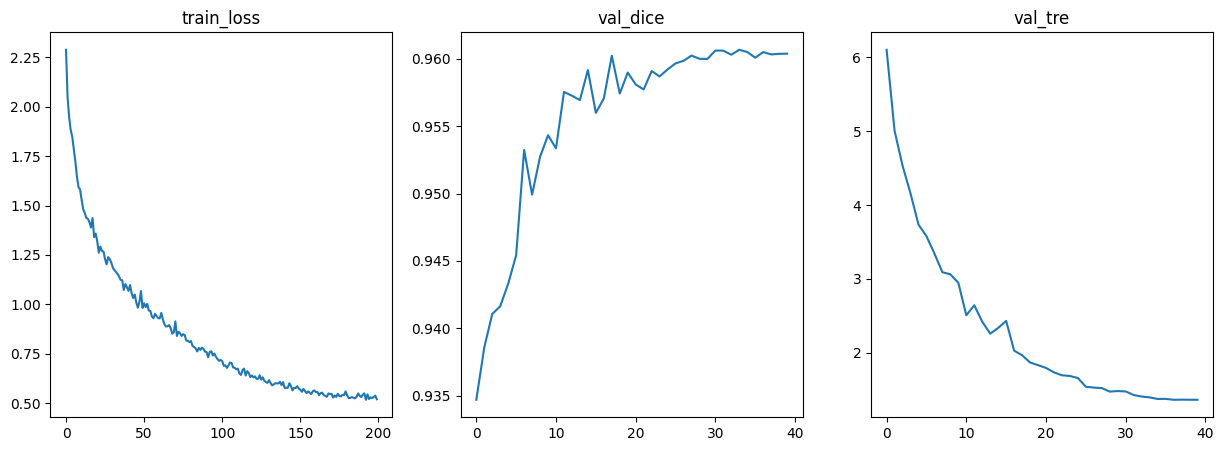

In [23]:
# log_val_tre = [x.item() for x in log_val_tre]
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].plot(log_train_loss)
axs[0].title.set_text("train_loss")
axs[1].plot(log_val_dice)
axs[1].title.set_text("val_dice")
axs[2].plot(log_val_tre)
axs[2].title.set_text("val_tre")
plt.show()

## Visualize registration performance of trained network

#### Load pretrained model and perform forward pass

In [ ]:
load_pretrained_model_weights = False
if load_pretrained_model_weights:
    dir_load = dir_save  # folder where network weights are stored
    # instantiate warp layer
    warp_layer = Warp().to(device)
    # instantiate model
    model = SegResNet(
        spatial_dims=3,
        in_channels=2,
        out_channels=3,
        blocks_down=[1, 2, 2, 4],
        blocks_up=[1, 1, 1],
        init_filters=16,
        dropout_prob=0.2,
    )
    # load model weights
    filename_best_model = glob.glob(os.path.join(dir_load, "segresnet_kpt_loss_best_tre*"))[0]
    model.load_state_dict(torch.load(filename_best_model))
    # to GPU
    model.to(device)

set_determinism(seed=1)
check_ds = Dataset(data=val_files, transform=val_transforms)
check_loader = DataLoader(check_ds, batch_size=1, shuffle=True)
check_data = first(check_loader)

# Forward pass
model.eval()
with torch.no_grad():
    with torch.cuda.amp.autocast(enabled=amp_enabled):
        ddf_image, ddf_keypoints, pred_image, pred_label = forward(
            check_data["fixed_image"].to(device),
            check_data["moving_image"].to(device),
            check_data["moving_label"].to(device),
            check_data["fixed_keypoints"].to(device),
            model,
            warp_layer,
        )

#### Visualization of image pair pre-/post-registration

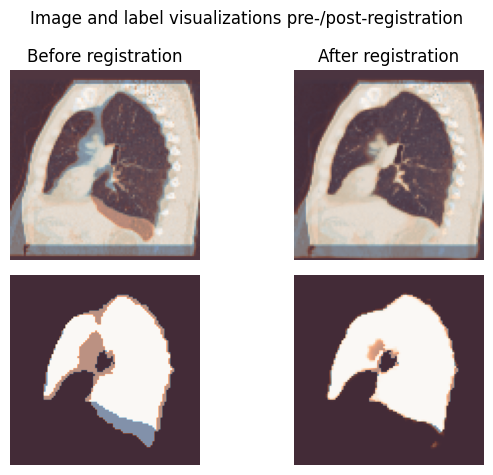

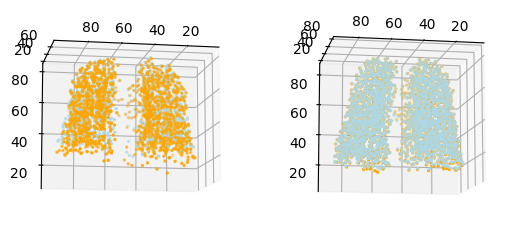

In [42]:
# Image and label visualization
fixed_image = check_data["fixed_image"][0][0].permute(1, 0, 2)
fixed_label = check_data["fixed_label"][0][0].permute(1, 0, 2)
moving_image = check_data["moving_image"][0][0].permute(1, 0, 2)
moving_label = check_data["moving_label"][0][0].permute(1, 0, 2)
pred_image = pred_image[0][0].permute(1, 0, 2).cpu()
pred_label = pred_label[0][0].permute(1, 0, 2).cpu()
# choose slice
slice_idx = int(target_res[0] * 95.0 / 224)  # visualize slice 95 at full-res (224 slices)
# plot images
fig, axs = plt.subplots(2, 2)
overlay_img(fixed_image, moving_image, slice_idx, axs[0, 0], "Before registration")
overlay_img(fixed_image, pred_image, slice_idx, axs[0, 1], "After registration")
# plot labels
overlay_img(fixed_label, moving_label, slice_idx, axs[1, 0])
overlay_img(fixed_label, pred_label, slice_idx, axs[1, 1])
for ax in axs.ravel():
    ax.set_axis_off()
plt.suptitle("Image and label visualizations pre-/post-registration")
plt.tight_layout()
plt.show()

# Pointcloud visualization
fixed_keypoints = check_data["fixed_keypoints"][0].cpu()
moving_keypoints = check_data["moving_keypoints"][0].cpu()
moved_keypoints = fixed_keypoints + ddf_keypoints[0].cpu()
# plot pointclouds
fig = plt.figure()
# Before registration
ax = fig.add_subplot(1, 2, 1, projection="3d")
ax.scatter(fixed_points[:, 0], fixed_points[:, 1], fixed_points[:, 2], s=2.0, marker="o", color="lightblue")
ax.scatter(moving_points[:, 0], moving_points[:, 1], moving_points[:, 2], s=2.0, marker="o", color="orange")
ax.view_init(-10, 80)
ax.set_aspect("auto")
# After registration
ax = fig.add_subplot(1, 2, 2, projection="3d")
ax.scatter(moved_keypoints[:, 0], moved_keypoints[:, 1], moved_keypoints[:, 2], s=2.0, marker="o", color="lightblue")
ax.scatter(moving_keypoints[:, 0], moving_keypoints[:, 1], moving_keypoints[:, 2], s=2.0, marker="o", color="orange")
ax.view_init(-10, 80)
ax.set_aspect("auto")
plt.show()

<a id='nextsteps'></a>
## Next steps

The registration network has been trained and achieves notably better alignment on validation samples that were not seen during training. As next steps, feel free to:

- Inspect other validation cases, either by looping through the validation and visualizing registration results.
- Instead of only using TRE as loss function, try different combinations of loss weights for the multi-target loss `loss_fun(...)` in code cell [Hyperparameters](#hyperparameters). You can either run optimization on a vanilla network, or you can finetune the network that was already trained with TRE.
- Train a network at full resolution. To this end, set the flag `full_res_training = True` in the above code cell [Transforms 2/2](#transforms_step2), and use `max_epochs = 2000` in cell [Hyperparameters](#hyperparameters). Expect training times of 2-4 days, depending on your GPU and batch-size. 
- With MONAI, it is very easy to swap out the `SegResNet` architecture for other SOTA models. For example, try to use a [UNet](https://docs.monai.io/en/stable/networks.html#unet)/[DynUNet](https://docs.monai.io/en/stable/networks.html#dynunet) or a 3D vision transformer architecture like [UNETR](https://docs.monai.io/en/stable/networks.html#unetr)/[SwinUNETR](https://docs.monai.io/en/stable/networks.html#swinunetr). It is also possible to bring-your-own-model (BYOM), as long as the model architecture derives from `torch.nn.Module`.

For further information on how to prepare a challenge submission from these results, please visit official recommendations from the [Learn2Reg](https://learn2reg.grand-challenge.org/) website. 